In [64]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI, AzureChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langgraph.types import Literal
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv
import os

In [65]:
load_dotenv(override=True)

True

In [88]:
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    route: Optional[Literal["sales_agent", "repair_agent", "END"]]  # Make it optional
    conversation_complete: bool  # Add flag to track completion

In [89]:
llm = AzureChatOpenAI(
    api_key=os.environ['OPENAI_API_AZURE_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    api_version=os.environ['OPENAI_API_VERSION'],
    model = os.environ['OPENAI_AZURE_MODEL'],
)

# Node Customer Service

In [90]:
class CustomerServiceResult(BaseModel):
    route: Literal["sales_agent", "repair_agent", "END"] = Field(
        ..., description="The route to take based on the user's request. Options are 'sales_agent', 'repair_agent', or 'END'."
    )
    answer: str = Field(
        ..., description="The response to the user when user not ask about repair or buy motorcycle."
    )

In [91]:
customer_service_llm = llm.with_structured_output(CustomerServiceResult)

In [ ]:
# def customer_service(state: State) -> Dict[str, Any]:

#     system_message = f"""You are a customer service agent for Broom Bot Inc, a motorcycle company that can sell motorcycle or repair motorcycle.
#     You will guide the customer to either buy a motorcycle or repair a motorcycle.
#     If user wants to buy a motorcycle, ask about the new model, or any question related to the user want to ask motorcycle model, you will direct them to the Sales Agent.
#     If user wants to repair a motorcycle, ask about their motor problem, and any related to the condition of the motor problem, you will direct them to the Repair Agent.
#     Respond with either "sales_agent" or "repair_agent" or "END" based on the user's request.
#     Just respond with the boolean value, do not explain anything.
#     If user the general question that not related to buy or repair motorcycle, you will answer the question and respond with "END".
#     """
#     print("state", state)
#     customer_service_messages = [
#         SystemMessage(content=system_message),
#         *state['messages']
#     ]
#     print("customer_service_messages", customer_service_messages)
#     customer_servce_result = customer_servce_llm.invoke(customer_service_messages)
#     print("cusomter service result", customer_servce_result)
#     new_state = {
#         "messages": state['messages'] + [AIMessage(content=customer_servce_result.answer)],
#         "route": customer_servce_result.route
#     }
#     print("new state", new_state)
#     return new_state
    

In [92]:
def customer_service(state: State) -> Dict[str, Any]:
    """Customer service node - routes requests or provides general answers"""
    print("=== CUSTOMER SERVICE NODE ===")
    print("Current state:", state)
    
    # Check if we're coming back from a specialist agent
    if len(state['messages']) > 1 and hasattr(state['messages'][-1], 'content'):
        last_message = state['messages'][-1]
        # If last message is from AI (specialist), we should end the conversation
        if isinstance(last_message, AIMessage):
            print("Detected specialist response, ending conversation")
            return {
                "messages": state['messages'],
                "route": "END",
                "conversation_complete": True
            }
    
    system_message = """You are a customer service agent for Broom Bot Inc, a motorcycle company that can sell motorcycle or repair motorcycle.
    
    You will guide the customer to either buy a motorcycle or repair a motorcycle.
    
    ROUTING RULES:
    - If user wants to buy a motorcycle, ask about new models, or any question related to motorcycle purchasing/models → route to "sales_agent"
    - If user wants to repair a motorcycle, ask about motor problems, maintenance, or any repair-related issues → route to "repair_agent"  
    - If user asks general questions not related to buying or repairing motorcycles → answer directly and route to "END"
    
    IMPORTANT: Only route to specialists for the INITIAL request. Do not route follow-up questions.
    """
    
    # Get only the user messages for routing decision
    user_messages = [msg for msg in state['messages'] if isinstance(msg, HumanMessage)]
    
    customer_service_messages = [
        SystemMessage(content=system_message),
        *user_messages  # Only include user messages for routing
    ]
    
    print("Messages sent to customer service LLM:", customer_service_messages)
    
    try:
        customer_service_result = customer_service_llm.invoke(customer_service_messages)
        print("Customer service result:", customer_service_result)
        
        # If routing to END, include the answer in messages
        if customer_service_result.route == "END":
            new_messages = state['messages'] + [AIMessage(content=customer_service_result.answer)]
            conversation_complete = True
        else:
            # If routing to specialist, don't add message yet
            new_messages = state['messages']
            conversation_complete = False
        
        new_state = {
            "messages": new_messages,
            "route": customer_service_result.route,
            "conversation_complete": conversation_complete
        }
        
        print("New state from customer service:", new_state)
        return new_state
        
    except Exception as e:
        print(f"Error in customer service: {e}")
        return {
            "messages": state['messages'] + [AIMessage(content="I apologize, but I'm having trouble processing your request. Please try again.")],
            "route": "END",
            "conversation_complete": True
        }


In [93]:
def route_based_on_evaluation(state: State) -> str:
    """Routing function for conditional edges"""
    print("=== ROUTING DECISION ===")
    print(f"Route: {state.get('route', 'None')}")
    print(f"Conversation complete: {state.get('conversation_complete', False)}")
    
    route = state.get('route', 'END')
    print(f"Routing to: {route}")
    return route

# Node Repair Agent

In [ ]:
# def repair_agent(state: State) -> Dict[str, Any]:
#     print("repair agent called")
#     print(state["messages"])
#     last_response = state["messages"][-1].content
#     print("last response", last_response)

#     system_message = """ You are a repair agent for Broom Bot Inc, a motorcycle company that can help user related to their motor problem.
#     Ask about their problem, and any related to the condition of the motor problem.
#     Give them the solution to their motor problem."""

#     repair_agent_messages = [
#         SystemMessage(content=system_message),
#         HumanMessage(content=last_response)
#     ]

#     result = llm.invoke(repair_agent_messages)
#     print("RESULT")
#     print(result)
#     return {
#         "messages": [result]
#     }

In [94]:
def repair_agent(state: State) -> Dict[str, Any]:
    """Repair agent - handles motorcycle repair requests"""
    print("=== REPAIR AGENT NODE ===")
    print("Current messages:", state["messages"])
    
    # Get the user's original request
    user_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    if not user_messages:
        return {
            "messages": state["messages"] + [AIMessage(content="I didn't receive your repair request. Please describe your motorcycle problem.")],
            "route": "END",
            "conversation_complete": True
        }
    
    latest_user_message = user_messages[-1].content
    print("Latest user message:", latest_user_message)

    system_message = """You are a repair agent for Broom Bot Inc, a motorcycle company that specializes in motorcycle repairs and maintenance.

    Your expertise includes:
    - Diagnosing motorcycle problems
    - Providing repair solutions and maintenance advice
    - Scheduling service appointments
    - Explaining repair procedures and costs
    - Troubleshooting mechanical and electrical issues

    Provide helpful, detailed responses about motorcycle repair and maintenance. Be professional and knowledgeable.
    
    After providing your response, the conversation will be complete unless the user has follow-up questions."""

    repair_messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=latest_user_message)
    ]

    try:
        result = llm.invoke(repair_messages)
        print("Repair agent result:", result)
        
        return {
            "messages": state["messages"] + [result],
            "route": "END",
            "conversation_complete": True
        }
    except Exception as e:
        print(f"Error in repair agent: {e}")
        return {
            "messages": state["messages"] + [AIMessage(content="I apologize, but I'm having trouble processing your repair request. Please contact our service department directly.")],
            "route": "END",
            "conversation_complete": True
        }

# Node Sales Agent

In [ ]:
# def sales_agent(state: State) -> str:
#     print("sales agent called")
#     print(state["messages"])
#     last_response = state["messages"][-1].content
#     print("last response", last_response)

#     system_message = """ You are a sales agent for Broom Bot Inc, a motorcycle company that can help user that ask about motorcycle that they want to buy.
#     Ask about what motor that they want to buy.
#     Give them the explanation to their motor model or anything that they ask about the motor."""

#     repair_agent_messages = [
#         SystemMessage(content=system_message),
#         HumanMessage(content=last_response)
#     ]

#     result = llm.invoke(repair_agent_messages)
#     print("RESULT")
#     print(result)
#     return {
#         "messages": [result]
#     }

In [95]:
def sales_agent(state: State) -> Dict[str, Any]:
    """Sales agent - handles motorcycle sales requests"""
    print("=== SALES AGENT NODE ===")
    print("Current messages:", state["messages"])
    
    # Get the user's original request
    user_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    if not user_messages:
        return {
            "messages": state["messages"] + [AIMessage(content="I didn't receive your sales inquiry. Please let me know what motorcycle you're interested in.")],
            "route": "END", 
            "conversation_complete": True
        }
    
    latest_user_message = user_messages[-1].content
    print("Latest user message:", latest_user_message)

    system_message = """You are a sales agent for Broom Bot Inc, a motorcycle company that specializes in selling motorcycles.

    Your expertise includes:
    - Recommending motorcycle models based on customer needs
    - Providing pricing information and financing options
    - Explaining motorcycle specifications and features
    - Arranging test rides and demonstrations
    - Processing sales inquiries and orders

    Available motorcycle categories:
    - Sport bikes: High performance, racing-oriented
    - Cruisers: Comfortable, touring-focused  
    - Adventure bikes: Versatile, on/off-road capability
    - Standard bikes: Balanced, everyday riding

    Provide helpful, informative responses about motorcycle sales and models. Be professional and enthusiastic about helping customers find their perfect motorcycle.
    
    After providing your response, the conversation will be complete unless the user has follow-up questions."""

    sales_messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=latest_user_message)
    ]

    try:
        result = llm.invoke(sales_messages)
        print("Sales agent result:", result)
        
        return {
            "messages": state["messages"] + [result],
            "route": "END",
            "conversation_complete": True
        }
    except Exception as e:
        print(f"Error in sales agent: {e}")
        return {
            "messages": state["messages"] + [AIMessage(content="I apologize, but I'm having trouble processing your sales inquiry. Please contact our sales department directly.")],
            "route": "END",
            "conversation_complete": True
        }

# Set Up Graph Builder

In [ ]:
# graph_builder = StateGraph(State)

# # Add Notes
# graph_builder.add_node("customer_service", customer_service)
# graph_builder.add_node("repair_agent", repair_agent)
# graph_builder.add_node("sales_agent", sales_agent)

# # Add Edges
# graph_builder.add_edge(START, "customer_service")
# graph_builder.add_edge("customer_service", END)
# graph_builder.add_conditional_edges("customer_service", route_based_on_evaluation, {"sales_agent": "sales_agent", "repair_agent": "repair_agent", "END": END})
# graph_builder.add_edge("repair_agent", "customer_service")
# graph_builder.add_edge("sales_agent", "customer_service")

# # compile the graph
# memory = MemorySaver()
# graph = graph_builder.compile(checkpointer=memory)

In [96]:
# Build the graph
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("customer_service", customer_service)
graph_builder.add_node("repair_agent", repair_agent)
graph_builder.add_node("sales_agent", sales_agent)

# Add edges - FIXED STRUCTURE
graph_builder.add_edge(START, "customer_service")

# Conditional edges from customer service
graph_builder.add_conditional_edges(
    "customer_service", 
    route_based_on_evaluation, 
    {
        "sales_agent": "sales_agent", 
        "repair_agent": "repair_agent", 
        "END": END
    }
)

# Both specialist agents go directly to END (no loop back)
graph_builder.add_edge("repair_agent", END)
graph_builder.add_edge("sales_agent", END)

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

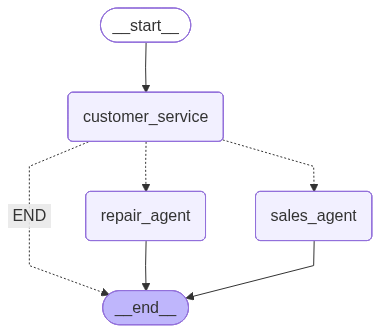

In [97]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Run

In [98]:
def make_thread_id() -> str:
    return str(uuid.uuid4())


In [99]:
thread = make_thread_id()
config = {"configurable": {"thread_id": thread}}

# Initial State
state = {
    "messages": "Hai, I have problem with my motor related to the tire, but I also want to buy a new motor the modelis BEAT",
    "route": None,
    "conversation_complete": False
}
result = await graph.ainvoke(state, config=config)

=== CUSTOMER SERVICE NODE ===
Current state: {'messages': [HumanMessage(content='Hai, I have problem with my motor related to the tire, but I also want to buy a new motor the modelis BEAT', additional_kwargs={}, response_metadata={}, id='27f963bf-a89d-4990-a8f9-b1d32920b5a9')], 'route': None, 'conversation_complete': False}
Messages sent to customer service LLM: [SystemMessage(content='You are a customer service agent for Broom Bot Inc, a motorcycle company that can sell motorcycle or repair motorcycle.\n\n    You will guide the customer to either buy a motorcycle or repair a motorcycle.\n\n    ROUTING RULES:\n    - If user wants to buy a motorcycle, ask about new models, or any question related to motorcycle purchasing/models → route to "sales_agent"\n    - If user wants to repair a motorcycle, ask about motor problems, maintenance, or any repair-related issues → route to "repair_agent"  \n    - If user asks general questions not related to buying or repairing motorcycles → answer dir

In [100]:
result

{'messages': [HumanMessage(content='Hai, I have problem with my motor related to the tire, but I also want to buy a new motor the modelis BEAT', additional_kwargs={}, response_metadata={}, id='27f963bf-a89d-4990-a8f9-b1d32920b5a9'),
  AIMessage(content="Hello! I'd be happy to help you with both your current motorcycle tire issue and with purchasing a new motorcycle model. \n\nRegarding your tire problem, could you provide a bit more detail about the issue? Are you experiencing a flat tire, uneven wear, or something else? I can offer some advice or solutions for that.\n\nAs for the BEAT model, could you clarify if you are referring to the Honda BeAT, as it's a popular scooter? It’s known for its agility and fuel efficiency, making it great for urban commuting. Are you looking for specific features or performance characteristics? Once I have a better understanding of your requirements, I can assist you with pricing options and the purchasing process.\n\nLooking forward to your response!"

In [101]:
result["messages"][-1].content

"Hello! I'd be happy to help you with both your current motorcycle tire issue and with purchasing a new motorcycle model. \n\nRegarding your tire problem, could you provide a bit more detail about the issue? Are you experiencing a flat tire, uneven wear, or something else? I can offer some advice or solutions for that.\n\nAs for the BEAT model, could you clarify if you are referring to the Honda BeAT, as it's a popular scooter? It’s known for its agility and fuel efficiency, making it great for urban commuting. Are you looking for specific features or performance characteristics? Once I have a better understanding of your requirements, I can assist you with pricing options and the purchasing process.\n\nLooking forward to your response!"

In [86]:
async def process_message(message, history, thread):

    config = {"configurable": {"thread_id": thread}}

    # Initial State
    state = {
        "messages": message,
        "route": None
    }
    result = await graph.ainvoke(state, config=config)
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-1].content}

    return history + [user, reply]

async def reset():
    return "", "", None, make_thread_id()

In [ ]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Broom Bot")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, chatbot, thread])

    
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


state {'messages': [HumanMessage(content='motor saya rusak nih', additional_kwargs={}, response_metadata={}, id='8cb58495-596a-4dae-9e3a-979111d65063')], 'route': None}
customer_service_messages [SystemMessage(content='You are a customer service agent for Broom Bot Inc, a motorcycle company that can sell motorcycle or repair motorcycle.\n    You will guide the customer to either buy a motorcycle or repair a motorcycle.\n    If user wants to buy a motorcycle, ask about the new model, or any question related to the user want to ask motorcycle model, you will direct them to the Sales Agent.\n    If user wants to repair a motorcycle, ask about their motor problem, and any related to the condition of the motor problem, you will direct them to the Repair Agent.\n    Respond with either "sales_agent" or "repair_agent" or "END" based on the user\'s request.\n    Just respond with the boolean value, do not explain anything.\n    If user the general question that not related to buy or repair mot

Traceback (most recent call last):
  File "/home/agrelvin8135@corp.ai.astra.co.id/Documents/Data/UdemyProject/Agentic-AI/.venv/lib/python3.12/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/agrelvin8135@corp.ai.astra.co.id/Documents/Data/UdemyProject/Agentic-AI/.venv/lib/python3.12/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/agrelvin8135@corp.ai.astra.co.id/Documents/Data/UdemyProject/Agentic-AI/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/agrelvin8135@corp.ai.astra.co.id/Documents/Data/UdemyProject/Agentic-AI/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 1729, in call_function
    pred